# OCR model for reading Captchas

* **Goal** :  Convert Keras model([Source](https://keras.io/examples/vision/captcha_ocr/)) into PyTorch model

## Load the data: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)
Let's download the data.

*  Completely Automated Public  Turing Test to tell Computers and Humans Apart
: 완전히 자동화된 공개 튜링 테스트

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf

from tqdm.notebook import tqdm

In [2]:
 !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
 !unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    552      0 --:--:-- --:--:-- --:--:--   550
100 8863k  100 8863k    0     0  22.8M      0 --:--:-- --:--:-- --:--:-- 22.8M


The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

## Preprocessing

In [3]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50
img_channel_size = 4

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Maximum length of any captcha:", max_length)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'8', '5', '4', 'x', 'e', 'n', '7', 'f', '6', 'm', 'g', 'p', 'c', 'y', 'd', 'b', '3', 'w', '2'}
Maximum length of any captcha: 5


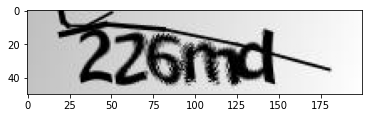



226md
size : (50, 200, 4)


In [4]:
img = imread(images[0])
plt.imshow(img)
plt.show()

print('\n')
print(labels[0])
print('size :', img.shape)

# RGBA :우리가 기본적으로 아는 RGB에 Alpha 채널을 추가한 것이다. Alpha는 이미지의 투명도(Transparent)를 나타낸 것이다.
# matplot imgread 는 이를 그대로 읽음

In [5]:
# Keras Version

from tensorflow import keras
from tensorflow.keras import layers

# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(char_to_num(tf.strings.unicode_split(['abc123','sdf123'], input_encoding="UTF-8")).to_tensor())

tf.Tensor(
[[-1 15 12 -1 18 16]
 [-1 14  7 -1 18 16]], shape=(2, 6), dtype=int64)


In [6]:
print(len(characters))

19


In [7]:
# PyTorch Version

class LabelConverter:
    """
      * char_set : {'y', 'p', 'd', 'b', 'e', '8', '2', 'w', '7', 'c', '4', '6', 'g', 'f', 'n', 'm', '5', '3', 'x'}
      * texts : ['22hmd','234df']
      * encode texts : tensor([[11, 11, 19, 10,  5],
                                  [11, 12, 13,  5,  7]])
      * decoded : ['22md', '234df']
    """

    def __init__(self, char_set):
        self.char_set = char_set
        self.char2num = dict(zip(list(char_set)+['-'], list(range(len(char_set)+1))))
        self.num2char = {num: char for char, num in self.char2num.items()}

    def encode(self, texts):
        """Mapping characters to numbers(integer)"""

        encoded_texts = []
        for text in texts:
            encoded_text_i = []
            for c in text:
                if c not in self.char_set:
                  # unkown token blank 처리 
                  encoded_text_i.append(self.char2num.get('-'))
                  continue
                encoded_text_i.append(self.char2num.get(c))
            encoded_texts.append(encoded_text_i)
        return torch.tensor(encoded_texts)

    def decode(self, encoded_texts):
        """Mapping integers back to original numbers(integer)"""

        decoded_texts = []
        for code in encoded_texts:
          decoded_num_i = []
          for num in code:
            if num not in self.char2num.values():
              continue
            decoded_num_i.append(self.num2char.get(num.item()))
          decoded_texts.append(decoded_num_i)

        decoded = []
        for text in decoded_texts:
          decoded_text = ''
          for i, t in enumerate(text):
              if t == '-':
                  continue
              decoded_text = decoded_text + t
          decoded.append(decoded_text)
          
        return decoded

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)

    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
        
    # 3. Get the size of training samples
    train_samples = int(size * train_size)

    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [9]:
print(x_train[0])
print(y_train[0])

captcha_images_v2/4fp5g.png
4fp5g


## Create `Dataset` objects

In [10]:
from torch.utils.data import Dataset, DataLoader

class OCRDataSet(Dataset):
    """
    torch.utils.data.Dataset은 데이터셋을 나타내는 추상클래스
    Custom Dataset은 Dataset에 상속하고 아래와 같이 override.

    DataLoader에서,
      __len__ 은 데이터셋의 크기를 반환 --> iterable 
      __getitem__ 은 i번째 샘플을 찾는데 사용
    """
    # images - image path list
    # labels - ground truth list
    def __init__(self, images, labels):
        self.images = images
        self.labels = self._encode_single_sample(labels)

    def __len__(self):
        return len(self.images)

    def _encode_single_sample(char_set, label):
        labels = LabelConverter(characters).encode(label)
        return labels

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = imread(self.images[idx])
        label = self.labels[idx]

        return {
            "image" : image, 
            "label" : label
        }


train_dataset = OCRDataSet(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

valid_dataset = OCRDataSet(x_valid, y_valid)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16, shuffle=False)



```
print(iter(train_loader).next())
print(iter(train_loader).next())

{'image': tensor([[[[0.7529, 0.7529, 0.7529, 1.0000],
           [0.7529, 0.7529, 0.7529, 1.0000],
           [0.7529, 0.7529, 0.7529, 1.0000],
           ...,
           [0.9843, 0.9843, 0.9843, 1.0000],
           [0.9843, 0.9843, 0.9843, 1.0000],
           [0.9843, 0.9843, 0.9843, 1.0000]],

 'label': tensor([[15,  8,  2,  3, 10],
         [ 9,  9, 17,  8,  8],
         [12,  7, 18,  1,  6],
         [ 8, 11, 14, 16, 15],
          ...,
         [ 7,  0, 16, 11, 12],
         [15,  6,  7,  4, 15],
         [ 8, 13, 14,  5, 16]])}
```



## Visualize the data

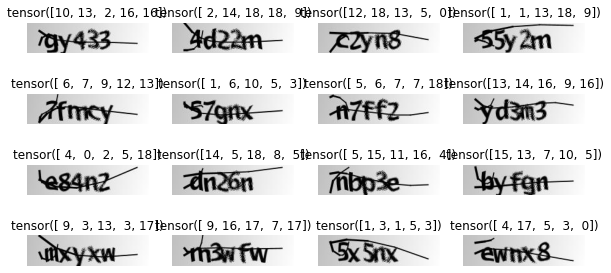

In [11]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for  i_batch, sample_batched in enumerate(train_loader):
    batch_images = sample_batched["image"]
    batch_labels = sample_batched["label"]
    if i_batch == 0:
      for i in range(16):
          img = (batch_images[i] * 255).numpy().astype("uint8")
          label = batch_labels[i]
          ax[i // 4, i % 4].imshow(img, cmap="gray")
          ax[i // 4, i % 4].set_title(label)
          ax[i // 4, i % 4].axis("off")
plt.show()

## Model

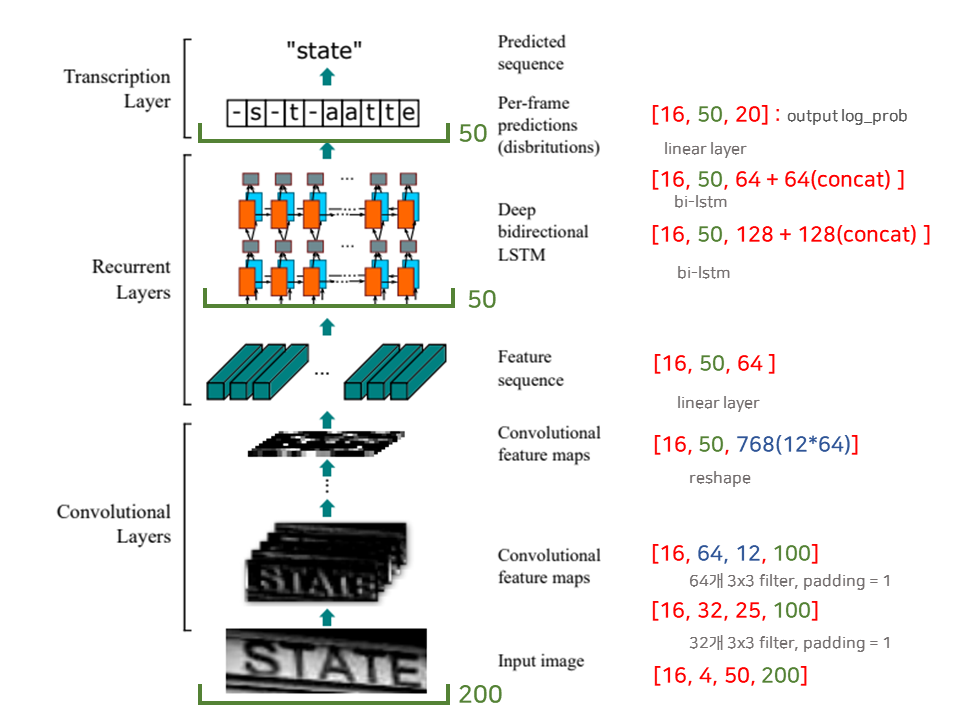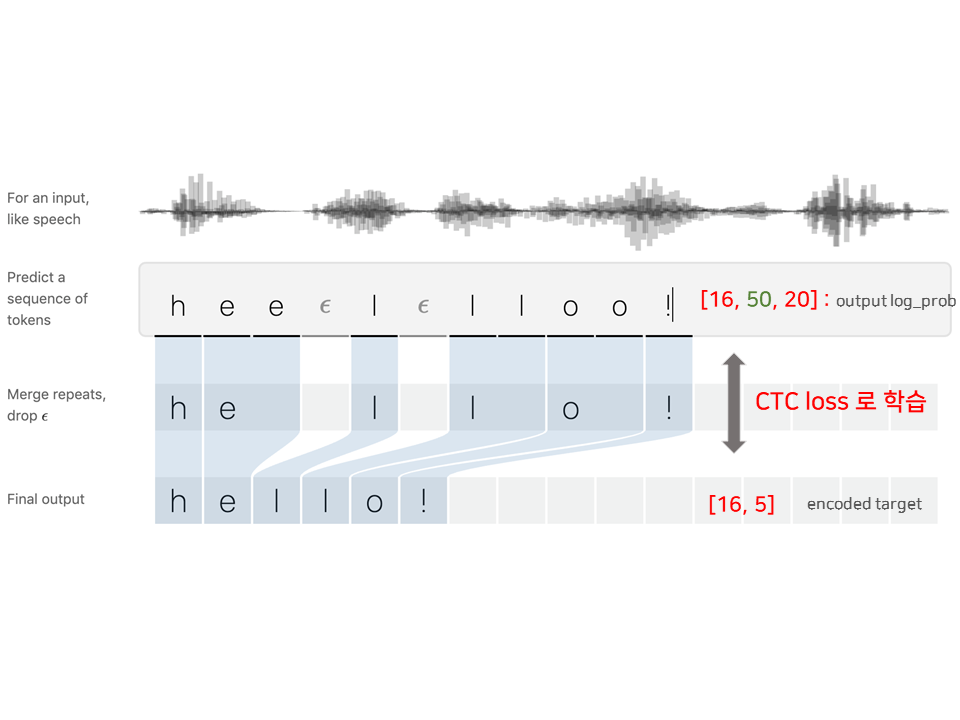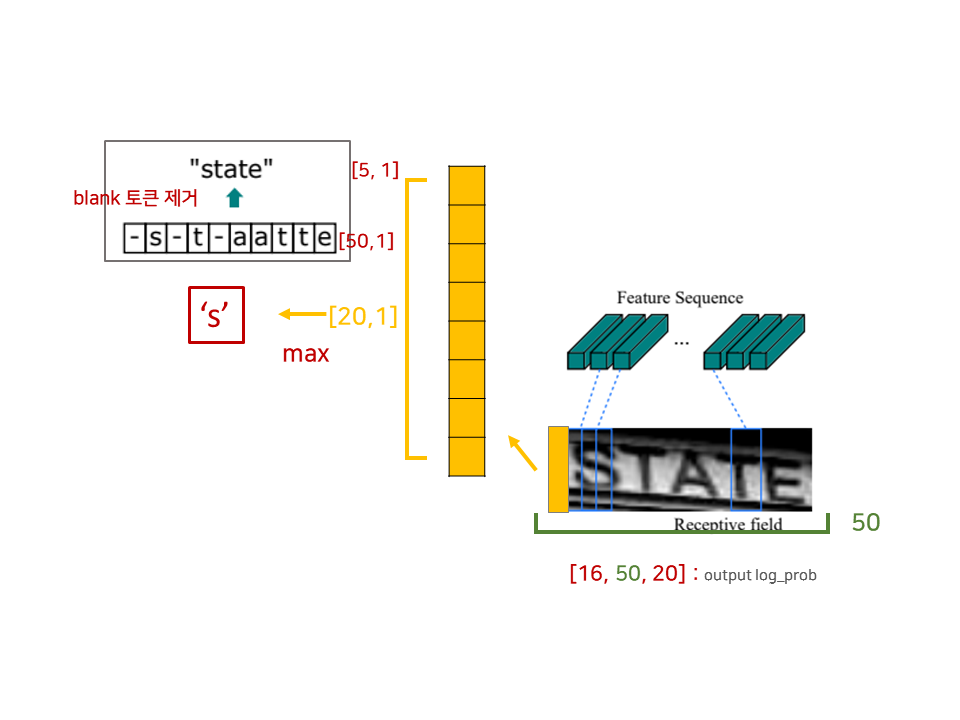

In [12]:

class CRNN(nn.Module):

  def __init__(self):
    super(CRNN, self).__init__()

    # TODO(subin): Assign 'self.<varible>' by the input of class argument

    self.input = None
    self.batch_size = batch_size
    
    self.img_channel_size = img_channel_size
    self.img_width = img_width
    self.img_height = img_height

    self.num_layers = 1
    self.downsample_factor = 4
    
    self.conv_hidden_1 = 32
    self.conv_hidden_2 = 64

    self.lstm_hidden_size_1 = 64
    self.lstm_hidden_size_2 = 128

    # pading=1이 되어야 output size 유지
    self.conv_mp_1 = nn.Sequential(
        nn.Conv2d(4,self.conv_hidden_1, kernel_size =3,  padding =1), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    
    self.conv_mp_2 = nn.Sequential(
        nn.Conv2d(self.conv_hidden_1,self.conv_hidden_2, kernel_size =3,  padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))   

    # cf. [50, 768] -> [50, 64]
    self.linear_1 = nn.Linear((self.img_height // self.downsample_factor) * self.conv_hidden_2 , self.conv_hidden_2 ) 
    self.bilstm_1 = nn.LSTM(self.lstm_hidden_size_1, self.lstm_hidden_size_2, self.num_layers, bidirectional=True, batch_first=True)
    self.bilstm_2 = nn.LSTM(self.lstm_hidden_size_2*2, self.lstm_hidden_size_1, self.num_layers, bidirectional=True, batch_first=True)
    self.linear_2 = nn.Linear(self.lstm_hidden_size_1*2, len(characters) + 1)


  def forward(self, x):
      """
        [            input shape            ] torch.Size([16, 4, 50, 200])
        [   1st conv with mp output shape   ] torch.Size([16, 32, 25, 100])
        [   2nd conv with mp output shape   ] torch.Size([16, 64, 12, 50])
        [      linear_1 output shape       ] torch.Size([16, 50, 64])
        [       bilstm_1 output shape       ] torch.Size([16, 50, 256])
        [       bilstm_2 output shape       ] torch.Size([16, 50, 128])
        [  linear_2 (softmax) output shape  ] torch.Size([16, 50, 20])

      """
  
      # Keras format - [batch_size, height, width, channels] 을 PyTorch format - [batch_size, channels, height, width] 으로
      # https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
      # height, wdith = 행, 열
      x = x.permute(0,3,1,2)

      batch_szie, channel, height, width = x.shape

      # Set initial states

      # TODO : initialize

      # 2 for bidirection, [num_layers * num_directions, batch, hidden_size]
      h1 = torch.zeros(self.num_layers*2, x.size(0), self.lstm_hidden_size_2).to(device)
      c1 = torch.zeros(self.num_layers*2, x.size(0), self.lstm_hidden_size_2).to(device)

      # 2 for bidirection, [num_layers * num_directions, batch, hidden_size]
      h2 = torch.zeros(self.num_layers*2, x.size(0), self.lstm_hidden_size_1).to(device) 
      c2 = torch.zeros(self.num_layers*2, x.size(0), self.lstm_hidden_size_1).to(device)

      # Convolution + Maxpooling
      out = self.conv_mp_1(x)
      out = self.conv_mp_2(out)

      # We have used two max pool with pool size and strides 2.
      # Hence, downsampled feature maps are 4x smaller. The number of
      # filters in the last layer is 64. Reshape accordingly before
      # passing the output to the RNN part of the model
      new_shape = (-1, (self.img_width // self.downsample_factor), (self.img_height // self.downsample_factor) * self.conv_hidden_2) 
      out = torch.reshape(out, new_shape) # [16, 50, 768(12*64)]

      # Linear + Relu + Dropout
      out = self.linear_1(out)
      out = F.relu(out)
      out = F.dropout(out, p=0.2)

      # BiLSTM - 1
      out, (h1, c1) = self.bilstm_1(out, (h1,c1))
      out = F.dropout(out, p=0.25)

      # BiLSTM - 2
      out, (h2, c2) = self.bilstm_2(out, (h2, c2))
      out = F.dropout(out, p=0.25)

      out = self.linear_2(out)

      return out

## Training & Validation

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

# model
model = CRNN().to(device)

# Loss and optimizer
learning_rate = 0.001

# blank : blank label idx
criterion = torch.nn.CTCLoss(blank=19, zero_infinity=False, reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 300

# Train the model
total_step = len(train_loader)
for epoch in tqdm(range(1, num_epochs+1)):
  for  i_batch, sample_batched in enumerate(train_loader):
        batch_images = sample_batched['image'].to(device)
        batch_labels = sample_batched['label'].to(device)  # target(ground truth)

        # Forward pass

        outputs = model(batch_images)                      # prediction [16, 50, 20]
       
        # Reshape `ouputs` to compute CTC loss
        # https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
        # outputs_log_prob -> [ctc_input_lengths, batch_size, num_characters]  (cf.[50, 16, 20])
        outputs = outputs.permute(1,0,2)             
        outputs_log_prob = F.log_softmax(outputs, 2)   # CTCLoss 의 input -> log probability

        # ctc_input_lengths -> dim = batch size, value = 50
        # ctc_target_lengths -> dim = batch size, value = 5
        ctc_input_lengths = torch.full((outputs_log_prob.size(1),), outputs_log_prob.size(0)) 
        ctc_target_lengths = torch.full((outputs_log_prob.size(1),), 5)

        loss = criterion(
            log_probs=outputs_log_prob, targets=batch_labels, input_lengths=ctc_input_lengths, target_lengths=ctc_target_lengths)

        loss = sum(loss)/len(loss) # average

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i_batch+1)%10 ==0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch, num_epochs, i_batch +1, total_step, loss.item()))
          
  # Validate the model at every 1-epoch 
  with torch.no_grad():
    val_loss = []
    for  i_batch, sample_batched in enumerate(valid_loader):
      batch_images = sample_batched["image"].to(device)
      batch_labels = sample_batched['label'].to(device)

      outputs = model(batch_images) 

      _, predicted = torch.max(outputs.data, 1)

      # Forward pass
      outputs = model(batch_images)

      outputs = outputs.permute(1,0,2)              
      outputs_log_prob = F.log_softmax(outputs, 2) 

      target_lengths = torch.full((outputs_log_prob.size(1),), 5)  
      input_lengths = torch.full((outputs_log_prob.size(1),), outputs_log_prob.size(0))

      loss = criterion(
          log_probs=outputs_log_prob, targets=batch_labels, target_lengths=target_lengths, input_lengths=input_lengths)      
      loss = sum(loss)/len(loss) 
      val_loss.append(loss.item())

     # Average validation loss
    print ('Epoch [{}/{}], Validation Loss: {:.4f}\n' 
                      .format(epoch, num_epochs, sum(val_loss)/len(val_loss)))   
# Save the model checkpoint
torch.save(model.state_dict(), '/content/model.ckpt')

Current device :  cuda


Epoch [1/300], Step [10/59], Loss: 24.4802
Epoch [1/300], Step [20/59], Loss: 18.9582
Epoch [1/300], Step [30/59], Loss: 16.6784
Epoch [1/300], Step [40/59], Loss: 16.7377
Epoch [1/300], Step [50/59], Loss: 16.0946
Epoch [1/300], Validation Loss: 16.2574

Epoch [2/300], Step [10/59], Loss: 16.1678
Epoch [2/300], Step [20/59], Loss: 16.5223
Epoch [2/300], Step [30/59], Loss: 16.3455
Epoch [2/300], Step [40/59], Loss: 16.4000
Epoch [2/300], Step [50/59], Loss: 16.2302
Epoch [2/300], Validation Loss: 16.2097

Epoch [3/300], Step [10/59], Loss: 16.4143
Epoch [3/300], Step [20/59], Loss: 16.3008
Epoch [3/300], Step [30/59], Loss: 16.3093
Epoch [3/300], Step [40/59], Loss: 16.4094
Epoch [3/300], Step [50/59], Loss: 16.1415
Epoch [3/300], Validation Loss: 16.2543

Epoch [4/300], Step [10/59], Loss: 16.4276
Epoch [4/300], Step [20/59], Loss: 16.3326
Epoch [4/300], Step [30/59], Loss: 16.3272
Epoch [4/300], Step [40/59], Loss: 16.3603
Epoch [4/300], Step [50/59], Loss: 16.4928
Epoch [4/300], Va

## Inference / Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[ predicted ] ['44f86nx', '6444', '448884', '244846', '5443463', '8447', '44', '448wf747', 'g646']
[  target   ] ['g6n7x', 'c6f8g', '4743p', 'b28g8', 'bm3p8', 'pwebm', 'xxney', '3bx86', 'ydd3g']


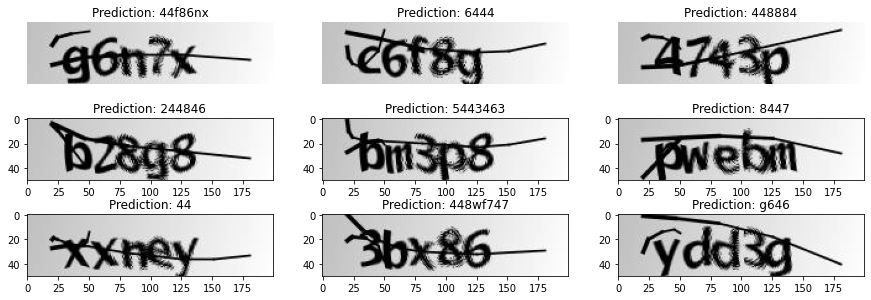

In [17]:
# Get the prediction model

test_model = CRNN()
test_model.load_state_dict(torch.load('/content/model.ckpt'))
test_model.to(device)
model.eval()

random_idx = torch.randperm(1040)[:9].numpy()
random_sample_images = torch.tensor(np.array([imread(images[idx]) for idx in list(random_idx)]))
random_sample_labels = [labels[idx] for idx in list(random_idx)]

#  Let's check results on some test samples

# Forward pass
outputs = test_model(torch.tensor(random_sample_images).to(device)) # [num_samples, 50, num_characters]

# Get prediction
_, predicted = torch.max(outputs.data, 1)                 # [num_samples, num_characters] 

# Map number to character
predicted_texts = LabelConverter(characters).decode(predicted) 

print('[ predicted ]', predicted_texts)
print('[  target   ]', random_sample_labels)

_, ax = plt.subplots(3, 3, figsize=(15, 5))
for i in range(len(predicted_texts)):
    img = (random_sample_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img
    title = f"Prediction: {predicted_texts[i]}"
    ax[i // 3, i % 3].imshow(img, cmap="gray")
    ax[i // 3, i % 3].set_title(title)
    ax[i // 43, i % 3].axis("off")
plt.show()



---

## Memo


In [15]:
# Softmax dim

m = nn.Softmax(dim=2)
input = torch.randn(2, 3, 4)
output = m(input)
print(output)
print(torch.sum(output,dim=2))

tensor([[[0.1805, 0.1026, 0.3485, 0.3684],
         [0.2074, 0.1232, 0.1818, 0.4876],
         [0.4493, 0.0824, 0.0727, 0.3957]],

        [[0.1143, 0.4897, 0.1735, 0.2224],
         [0.3308, 0.0391, 0.2411, 0.3890],
         [0.1533, 0.0127, 0.3179, 0.5161]]])
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]])


## Reference

* PyTorch documentation

  [PyTorch docs - torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

  [PyTorch docs - torch.nn.functional](https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.ctc_loss)

* Model Description

  [PyTorch CRNN Architecture](https://hackernoon.com/latest-deep-learning-ocr-with-keras-and-supervisely-in-15-minutes-34aecd630ed8)

* PyTorch Implementation Open Source

  [PyTorch OCR Implementation(1)](https://codingvision.net/pytorch-crnn-seq2seq-digits-recognition-ctc)

  [PyTorch OCR Implementation(2)](https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html#defining-our-model)

  [PyTorch OCR Implementation(3)](https://actamachina.com/notebooks/2019/03/28/captcha.html)

  [PyTorch OCR Implementation(4)](https://www.kaggle.com/gokulkarthik/captcha-text-recognition-using-crnn-in-pytorch)

  [PyTorch RNN Implenemtation](https://zzsza.github.io/data/2018/03/17/pytorch-rnn/)

* CTC Loss

  [CTC Loss Explanation](https://ratsgo.github.io/speechbook/docs/neuralam/ctc)

* Code Tips

  [PyTorch Code Tips](https://gaussian37.github.io/dl-pytorch-snippets/#nndropout-vs-fdropout-1)
